### Testing Librosa waveform

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
import matplotlib.pyplot as plt

from statistics import NormalDist

from sklearn.decomposition import PCA

from librosa import load as load_audio
from librosa import stft, amplitude_to_db
from librosa.display import specshow

from scipy.ndimage import label as label_features
from scipy.ndimage import maximum_position as extract_region_maximums
from scipy.spatial.distance import cdist


In [2]:
def display_wave_form(filepath):
    # Load the audio file
    y, sr = librosa.load(filepath)

    # Plot the waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

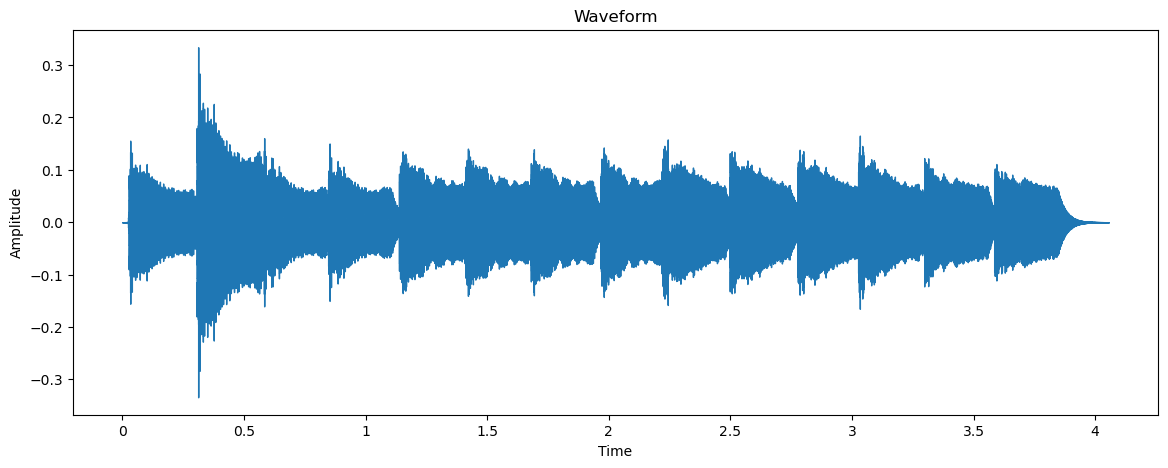

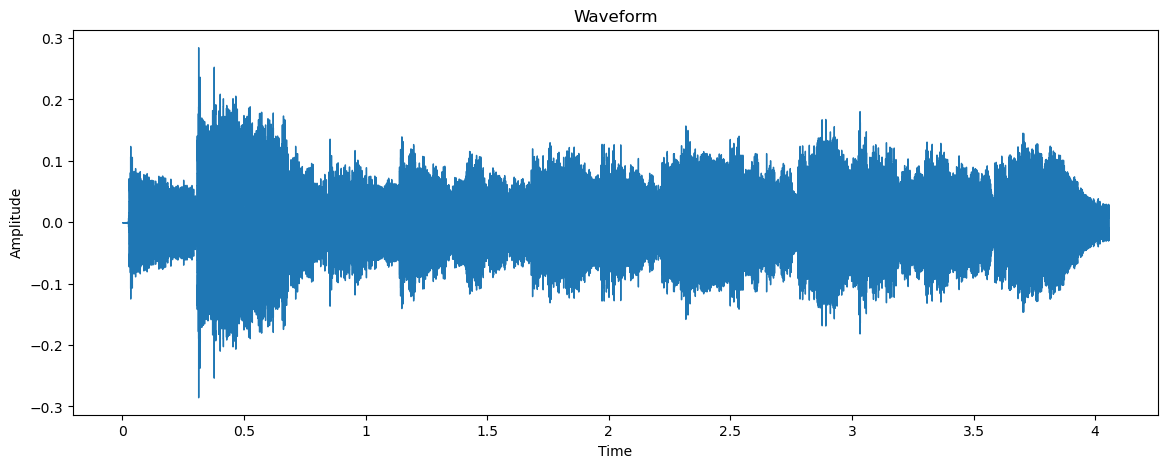

In [4]:
display_wave_form("audios/scala.mp3")
display_wave_form("audios/scala_Reverb_low.mp3")

### Spectrogram

In [4]:
def plot_spectrogram(file_path):
    # Load the MP3 file using librosa
    y, sr = librosa.load(file_path, sr=None)
    
    # Print audio information
    print(f"Audio File: {file_path}")
    print(f"Sample Rate (Hz): {sr}")
    print(f"Audio Length (seconds): {len(y) / sr:.2f}")

    # Compute the Short-Time Fourier Transform (STFT)  
    N_FFT = 2048  # FFT window size
    N_O = N_FFT // 4
    D = librosa.stft(y, n_fft=N_FFT)
    print(f"D shape: {D.shape}")
    
    frame_rate = sr / N_O
    print(f"Frame Rate (Hz): {frame_rate:.2f}")
  
    # Convert the complex-valued STFT result to magnitude
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='inferno')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

In [5]:
# Plot spectrogram for the first MP3 file
#plot_spectrogram('D5_acoustic_guitar.mp3')

# Plot spectrogram for the second MP3 file
#plot_spectrogram('D5_acoustic_guitar_with_reverb.mp3')

### Constellation Map tests

In [6]:
from matplotlib.patches import Rectangle

def constellation_map_builder(file_path): 
    #step 1: Set parameters
    N_FFT = 2048  # FFT window size
    N_O = N_FFT // 4

    #step 2: Load audio file
    y, sr = librosa.load(file_path, sr=None)

    #step 3: Compute the spectrogram
    D = librosa.stft(y, n_fft=N_FFT, hop_length=N_O)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    #step 4: Define window lengths for peak detection  
    d_t = 30
    d_f = 30

    #step 5: Select settings for peak detection
    #using maximum filter to detect local maxima
    local_max = maximum_filter(S_db, size=(d_t, d_f))

    #step 6: Create an identification matrix
    peaks = (S_db == local_max)  # Peaks are where the original value is equal to the local max

    #step 6.5: Apply an amplitude threshold to filter out insignificant peaks
    amplitude_threshold = -30  # dB, adjust as needed
    peaks &= (S_db > amplitude_threshold)

    #step 7: Extract peaks (time, frequency, amplitude)
    times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=N_O)
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=N_FFT)

    peak_indices = np.where(peaks)
    peak_times = times[peak_indices[1]]
    peak_freqs = frequencies[peak_indices[0]]
    peak_ampls = S_db[peak_indices]

    #normalize amplitudes for color mapping
    norm_ampls = (peak_ampls - np.min(peak_ampls)) / (np.max(peak_ampls) - np.min(peak_ampls))

    #save the peaks to a file (optional)
    peak_data = np.vstack((peak_times, peak_freqs, peak_ampls)).T
    peak_data_filtered = np.array([[round(x, 1), round(y, 1)] for x, y, _ in peak_data])
    np.savetxt('peaks.csv', peak_data_filtered, delimiter=',', header='Time,Frequency', comments='')
    #plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 7), sharex=True)

    #plot the spectrogram with peaks

    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='inferno', ax=ax[0])
    
    # Add rectangles to indicate the windows for local maxima detection
    #num_frames = S_db.shape[1]
    #num_bins = S_db.shape[0]
    #frame_time = librosa.frames_to_time(np.arange(num_frames), sr=sr, hop_length=N_O)
    #bin_freq = librosa.fft_frequencies(sr=sr, n_fft=N_FFT)
    
    #for i in range(0, num_frames, d_t):
    #    for j in range(0, num_bins, d_f):
    #        rect = Rectangle((frame_time[i], bin_freq[j]), frame_time[min(i+d_t, num_frames-1)] - frame_time[i], bin_freq[min(j+d_f, num_bins-1)] - bin_freq[j], 
    #                         linewidth=1, edgecolor='green', facecolor='none', alpha=0.3)
    #        ax[0].add_patch(rect)
            
    sc = ax[1].scatter(peak_times, peak_freqs, c=norm_ampls, cmap='inferno', marker='x')
    ax[0].set_title('Spectrogram')
    ax[1].set_title('Constellation Map')
    ax[0].set_xlabel('Time (s)')
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Hz')
    ax[1].set_ylabel('Hz')
    fig.colorbar(sc, ax=ax[1], format="%1.1f dB", norm=norm_ampls)

    plt.show()
    
    return peak_data_filtered

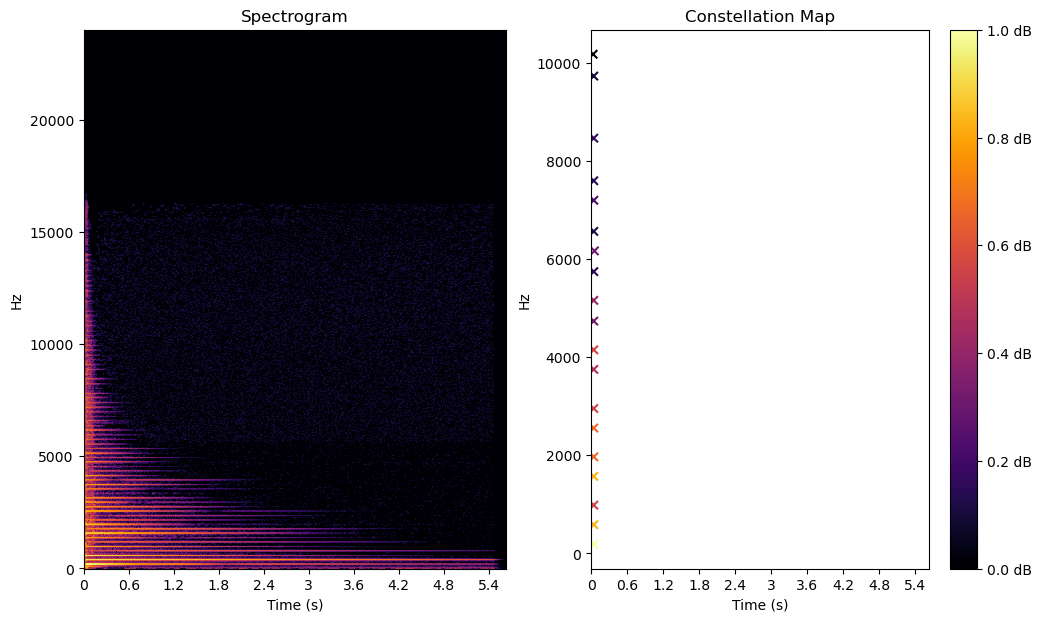

[[0.00000e+00 1.87500e+02]
 [0.00000e+00 5.85900e+02]
 [0.00000e+00 9.84400e+02]
 [0.00000e+00 1.57030e+03]
 [0.00000e+00 1.96880e+03]
 [0.00000e+00 2.55470e+03]
 [0.00000e+00 2.95310e+03]
 [0.00000e+00 3.75000e+03]
 [0.00000e+00 4.14840e+03]
 [0.00000e+00 4.73440e+03]
 [0.00000e+00 5.15620e+03]
 [0.00000e+00 5.74220e+03]
 [1.00000e-01 6.16410e+03]
 [0.00000e+00 6.56250e+03]
 [0.00000e+00 7.19530e+03]
 [0.00000e+00 7.59380e+03]
 [0.00000e+00 8.46090e+03]
 [0.00000e+00 9.72660e+03]
 [0.00000e+00 1.01719e+04]]


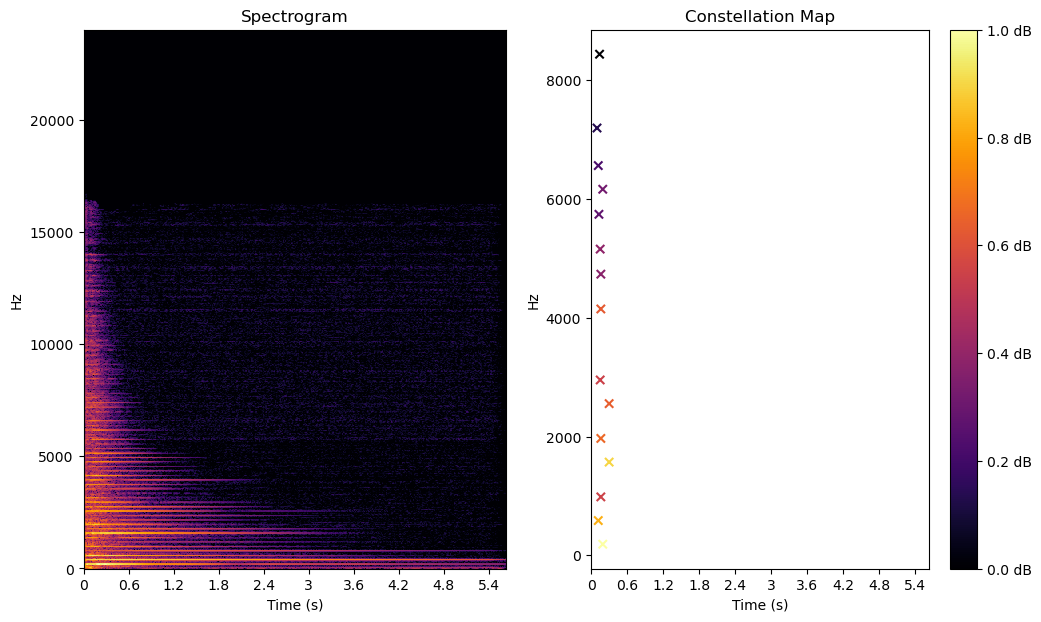

[[2.0000e-01 1.8750e+02]
 [1.0000e-01 5.8590e+02]
 [2.0000e-01 9.8440e+02]
 [3.0000e-01 1.5703e+03]
 [2.0000e-01 1.9688e+03]
 [3.0000e-01 2.5547e+03]
 [1.0000e-01 2.9531e+03]
 [2.0000e-01 4.1484e+03]
 [2.0000e-01 4.7344e+03]
 [1.0000e-01 5.1562e+03]
 [1.0000e-01 5.7422e+03]
 [2.0000e-01 6.1641e+03]
 [1.0000e-01 6.5625e+03]
 [1.0000e-01 7.1953e+03]
 [1.0000e-01 8.4375e+03]]


In [7]:
print(constellation_map_builder('audios/G4_guitar.mp3'))
print(constellation_map_builder('audios/G4_guitar_Reverb_high.mp3'))

### Other constellation map alg [USED NOW]

In [7]:
def z_score_peaks_calculation(file_path, threshold):
    y, _ = librosa.load(path=file_path, sr=None)

    #do transformations
    x = librosa.stft(y)
    x = librosa.amplitude_to_db(abs(x))
    
    #remove zero values
    flattened = np.matrix.flatten(x)
    filtered = flattened[flattened > np.min(flattened)]

    #create a normal distribution from frequency intensities
    #then map a zscore onto each intensity value
    ndist = NormalDist(np.mean(filtered), np.std(filtered))
    zscore = np.vectorize(lambda x: ndist.zscore(x))
    zscore_matrix = zscore(x)

    #create label matrix from frequency intensities that are
    #above threshold
    mask_matrix = zscore_matrix > threshold
    labelled_matrix, num_regions = label_features(mask_matrix)
    label_indices = np.arange(num_regions) + 1

    #for each isolated region in the mask, identify the maximum
    #value, then extract it position
    peak_positions = extract_region_maximums(zscore_matrix, labelled_matrix, label_indices)

    #finally, create list of peaks (time, frequency, intensity)
    peaks = [[x, y] for y, x in peak_positions]

    return peaks

In [12]:
print(z_score_peaks_calculation('audios/G4_guitar.mp3', 1.5))
print(z_score_peaks_calculation('audios/G4_guitar_Reverb_high.mp3', 1.5))

[[4, 8], [27, 0], [55, 0], [76, 0], [82, 0], [89, 0], [104, 0], [117, 0], [135, 0], [154, 0], [166, 0], [174, 2], [197, 0], [215, 0], [225, 0], [231, 0], [245, 0], [255, 0], [273, 0], [288, 2], [294, 0], [312, 0], [333, 0], [337, 0], [346, 0], [362, 0], [370, 0], [376, 0], [386, 2], [410, 0], [429, 0], [437, 0], [464, 0], [483, 0], [512, 0], [284, 2], [319, 2], [68, 2], [71, 2], [88, 2], [94, 2], [108, 2], [111, 2], [121, 2], [147, 2], [181, 2], [249, 2], [253, 2], [263, 2], [266, 3], [269, 2], [276, 3], [281, 2], [296, 2], [300, 2], [315, 2], [322, 2], [335, 2], [349, 2], [355, 2], [361, 2], [380, 2], [382, 2], [451, 3], [485, 3], [110, 3], [172, 3], [180, 3], [283, 3], [318, 3], [348, 3], [384, 3], [429, 3], [458, 3], [80, 5], [510, 8], [90, 12], [93, 12], [104, 12], [115, 12], [89, 13], [172, 13], [179, 13], [40, 21], [47, 21], [59, 21], [54, 22], [78, 22], [86, 22], [311, 25], [83, 28], [41, 31], [384, 33], [95, 37], [35, 38], [46, 39], [48, 39], [53, 39], [62, 39], [229, 42], [234

In [9]:
def add_epsilon_to_zeros(D, epsilon):
  D_copy = D.copy()  # Create a copy to avoid modifying the original array
  D_copy[D_copy == 0.0] = epsilon
  return D_copy

# Initialize membership matrix U based on initial distances and neighborhood function
def initialize_membership(X, Y, epsilon):
    n, m = len(X), len(Y)
    D = cdist(X, Y, metric='euclidean')
    D = add_epsilon_to_zeros(D, epsilon)
    U = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            U[i, j] = 1.0 / np.sum([(D[i, j] / (D[i, k])) ** 2 for k in range(m)])
    return U

# Update membership matrix using FOCM
def update_membership(U, D, gamma, n_clusters):
    n, m = U.shape
    for i in range(n):
        for j in range(m):
            denominator = np.sum([(D[i, j] / (D[i, k])) ** (2 / (gamma - 1)) for k in range(n_clusters)])
            U[i, j] = 1.0 / denominator
    return U

# Calculate new cluster centers
def calculate_cluster_centers(U, X, gamma):
  U_gamma = np.power(U.T, gamma)
  return (U_gamma @ X) / np.sum(U_gamma, axis=1, keepdims=True)

In [10]:
# FOCM algorithm
def focm(X, Y, n_clusters, max_iter=50, epsilon=1e-4, gamma=5):
    #start = time.time()

    U = initialize_membership(X, Y, epsilon)
    V = np.copy(Y)
    prev_U = np.zeros_like(U)

    for _ in range(max_iter):
        # Calculate distances
        D = cdist(X, V, metric='euclidean')
        D = add_epsilon_to_zeros(D, epsilon)

        # Update membership matrix
        U = update_membership(U, D, gamma, n_clusters)
        
        # Calculate new cluster centers
        V = calculate_cluster_centers(U, X, gamma)
        
        # Check for convergence
        if np.linalg.norm(U - prev_U) < epsilon:
            break
        prev_U = np.copy(U)
        
    #end = time.time()
    #print(f"Elapsed time FOCM: {round(end - start, 2)}")
    return U

In [11]:
from copy import deepcopy

# Calculate dissimilarity
def calculate_dissimilarity(file_path, output_file_path, threshold):
    #M_A = constellation_map_builder(file_path)
    #M_B = constellation_map_builder(output_file_path)
    peaks_1 = z_score_peaks_calculation(file_path, threshold)
    peaks_2 = z_score_peaks_calculation(output_file_path, threshold)
    
    M_A = None
    M_B = None
    
    if len(peaks_1) > len(peaks_2):
        n_clusters = len(peaks_2)
        M_A = deepcopy(peaks_1)
        M_B = deepcopy(peaks_2)
    else:
        n_clusters = len(peaks_1)
        M_A = deepcopy(peaks_2)
        M_B = deepcopy(peaks_1)        
        
    n_clusters = len(M_B)
    U = focm(M_A, M_B, n_clusters)

    total_distance = 0

    for i in range(len(M_A)):
        for j in range(len(M_B)):
            total_distance += U[i, j] * euclidean_distance(M_A[i], M_B[j])

    return total_distance / (len(M_A) * len(M_B))

In [12]:
file_path = 'audios/G4_guitar.mp3'

notes = ["audios/G4_guitar.mp3" ]

for note in notes: 
    dissimilarity = calculate_dissimilarity(file_path, note, threshold=3.5)
    print(f"Dissimilarity between G4 and {note[7:10]}: {dissimilarity}")

Dissimilarity between G4 and G4_: 2.1142427442675657e-05


Reverb applied, intensity: low
Dissimilarity: 0.4645559018268995
Reverb applied, intensity: medium
Dissimilarity: 0.5567998729900829
Reverb applied, intensity: high
Dissimilarity: 0.711209751620693
Chorus applied, intensity: low
Dissimilarity: 2.011668309510395
Chorus applied, intensity: medium
Dissimilarity: 1.6868263561776426
Chorus applied, intensity: high
Dissimilarity: 1.8396648275656866
Distortion applied, intensity: low
Dissimilarity: 0.432403593987819
Distortion applied, intensity: medium
Dissimilarity: 0.9964504064787166
Distortion applied, intensity: high
Dissimilarity: 1.0881410128363218
Delay applied, intensity: low
Dissimilarity: 0.9915878289520066
Delay applied, intensity: medium
Dissimilarity: 2.35600855756335
Delay applied, intensity: high
Dissimilarity: 3.1202527924173196
Phaser applied, intensity: low
Dissimilarity: 1.229182209678743
Phaser applied, intensity: medium
Dissimilarity: 1.37651024400248
Phaser applied, intensity: high
Dissimilarity: 1.4079569450520388
Comp

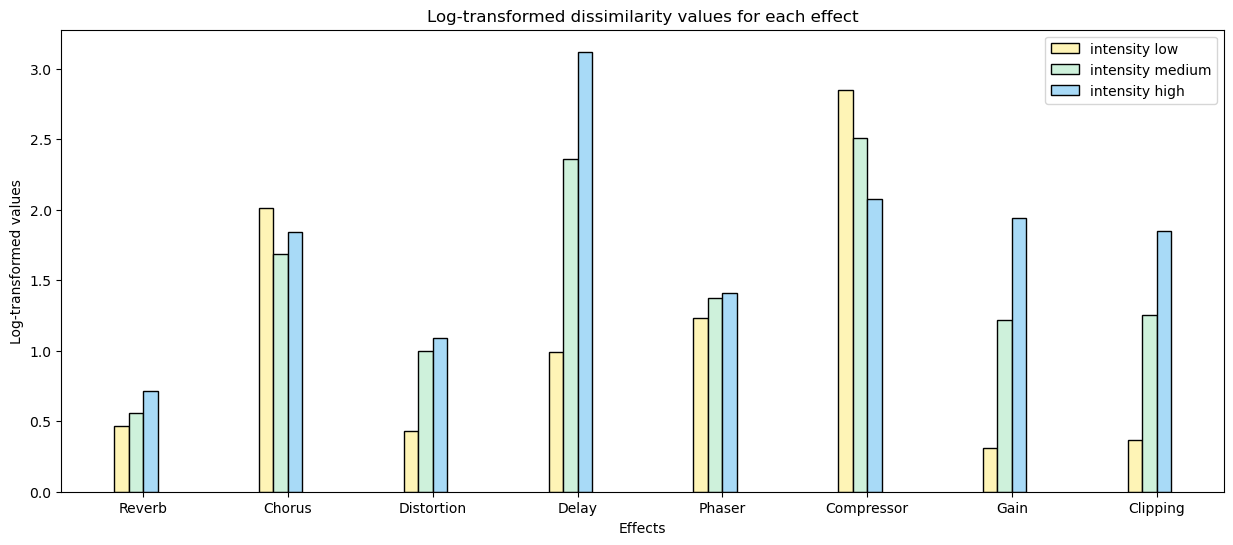

In [14]:
import matplotlib.pyplot as plt
import numpy as np

effects = ['Reverb', 'Chorus', "Distortion", 'Delay', 'Phaser', 'Compressor', 'Gain', "Clipping"]
intensities = ["low", "medium", "high"]

# Initialize dissimilarities as a list of lists
dissimilarities = {effect: [] for effect in effects}

file_path = 'audios/G4_guitar.mp3'
threshold = 3

for effect in effects:
    for intensity in intensities: 
        file_tested = 'audios/G4_guitar_' + str(effect) + "_" + str(intensity) + ".mp3"
        
        dissimilarity = calculate_dissimilarity(file_path, file_tested, threshold)
        dissimilarities[effect].append(dissimilarity)
        print(f"{effect} applied, intensity: {intensity}")
        print(f"Dissimilarity: {dissimilarity}")
    

# Apply logarithmic transformation to the data
#transformed_data = {key: [np.log10(value + 1) for value in values] for key, values in dissimilarities.items()}
transformed_data = dissimilarities

# Prepare the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Colors for the bars
colors = ['#FEF4B6','#CEF1DB', "#a8daf7"]

# Plotting the data
keys = list(transformed_data.keys())
values = np.array(list(transformed_data.values()))

bar_width = 0.1
indices = np.arange(len(keys))

intensities = ["low", "medium", "high"]

# Create bars for each value
for i in range(values.shape[1]):
    ax.bar(indices + i * bar_width, values[:, i], bar_width, label=f'intensity {intensities[i]}', color=colors[i], edgecolor='black')

# Labeling the graph
ax.set_xlabel('Effects')
ax.set_ylabel('Log-transformed values')
ax.set_title('Log-transformed dissimilarity values for each effect')
ax.set_xticks(indices + bar_width * 1.5)  # Adjust for centering
ax.set_xticklabels(keys)
ax.legend()

# Show the plot
plt.show()


In [52]:
# Sample constellation maps
#M_A = np.array([(11, 22), (23, 31), (14, 15)])
#M_B = np.array([(1, 2), (2, 3), (4, 5), (5, 6), (6, 7), (7, 8)])      

peak_data_filtered_no_effect = constellation_map_builder('audios/G4_guitar_Phaser_low.mp3')
peak_data_filtered_with_effect = constellation_map_builder('audios/G4_guitar_Phaser_high.mp3')

if len(peak_data_filtered_no_effect) < len(peak_data_filtered_with_effect):
    M_A = peak_data_filtered_no_effect
    M_B = peak_data_filtered_with_effect
else:
    M_A = peak_data_filtered_with_effect
    M_B = peak_data_filtered_no_effect



# Running FOCM algorithm
n_clusters = len(M_B)
U, V = focm(M_A, M_B, n_clusters)

dissimilarity = calculate_dissimilarity(M_A, M_B, U)
print(f"Dissimilarity: {dissimilarity}")


Dissimilarity: 2.0454358896173788


Reverb applied, intensity: low
len(TA): 16
 len(TB): 66
 len(sampled_TA): 16
 len(sampled_TB): 66
Iteration 0
Difference between U_new and U: 1.5816320105644737
Iteration 1
Difference between U_new and U: 1.7824595285466631
Iteration 2
Difference between U_new and U: 2.4614072463795327
Iteration 3
Difference between U_new and U: 2.639332194121587
Iteration 4
Difference between U_new and U: 2.702718137310181
Iteration 5
Difference between U_new and U: 1.651913835512597
Iteration 6
Difference between U_new and U: 1.348593127689728
Iteration 7
Difference between U_new and U: 1.5051448637749045
Iteration 8
Difference between U_new and U: 0.7357643364502657
Iteration 9
Difference between U_new and U: 0.4018423948313887
Iteration 10
Difference between U_new and U: 0.20008892825770053
Iteration 11
Difference between U_new and U: 0.11541210660412227
Iteration 12
Difference between U_new and U: 0.07852813896507908
Iteration 13
Difference between U_new and U: 0.057967289562971
Iteration 14
Diffe

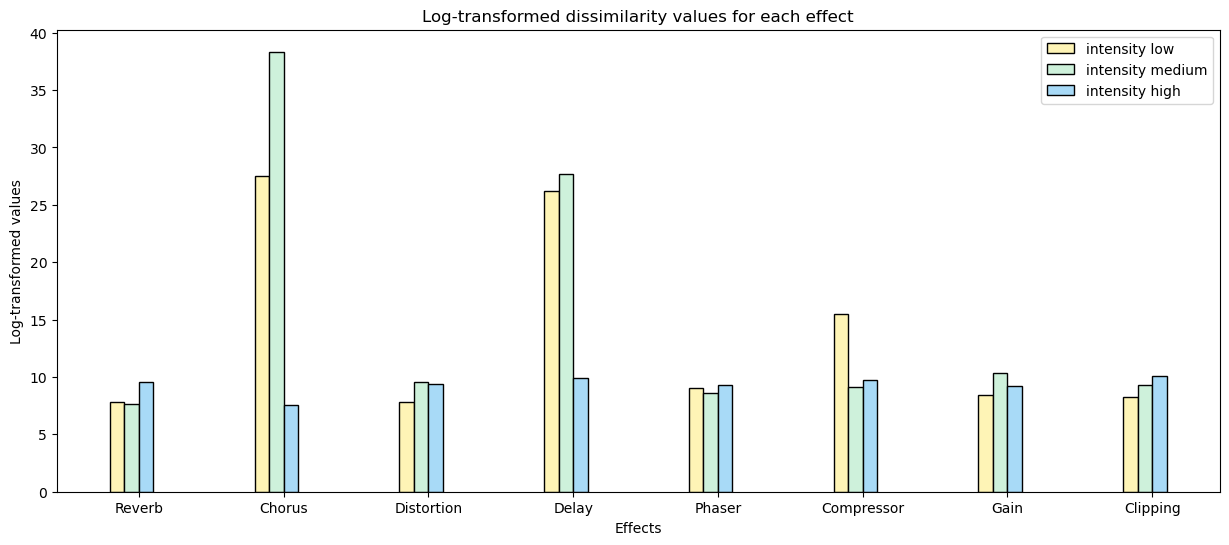

In [82]:
import numpy as np

def initialize_membership_matrix(n, c):
    # Initialize a random partition matrix U with constraints
    U = np.random.rand(n, c)
    U = U / np.sum(U, axis=1, keepdims=True)
    return U

def compute_centroids(X, U, c, lambda_exp):
    # Calculate the centroids for each cluster
    n_features = X.shape[1]
    centroids = np.zeros((c, n_features))
    for j in range(c):
        numerator = np.sum((U[:, j] ** lambda_exp)[:, np.newaxis] * X, axis=0)
        denominator = np.sum(U[:, j] ** lambda_exp)
        centroids[j, :] = numerator / denominator
    return centroids

def update_membership_matrix(X, centroids, c, lambda_exp):
    # Update the membership matrix U
    n = X.shape[0]
    U_new = np.zeros((n, c))
    for i in range(n):
        for j in range(c):
            sum_terms = np.sum([(np.linalg.norm(X[i] - centroids[j]) / np.linalg.norm(X[i] - centroids[k])) ** (2 / (lambda_exp - 1)) for k in range(c)])
            U_new[i, j] = 1 / sum_terms
    return U_new

def fuzzy_c_means(X, c, lambda_exp=2, max_iter=20, tolerance=1e-4):
    # Fuzzy C-Means Clustering Algorithm
    n = X.shape[0]
    U = initialize_membership_matrix(n, c)
    
    for _ in range(max_iter):
        print(f"Iteration {_}")
        centroids = compute_centroids(X, U, c, lambda_exp)
        U_new = update_membership_matrix(X, centroids, c, lambda_exp)
        
        print(f"Difference between U_new and U: {np.linalg.norm(U_new - U)}")
        # Check for convergence
        if np.linalg.norm(U_new - U) < tolerance:
            break
        U = U_new
    
    return U, centroids

def calculate_dissimilarity(TA, TB, U):
    # Calculate the dissimilarity based on FCM
    n, m = len(TA), len(TB)
    dissimilarity = 0
    for i in range(n):
        for j in range(m):
            dissimilarity += U[i, j] * np.linalg.norm(TA[i] - TB[j])
    return dissimilarity / (n * m)


effects = ['Reverb', 'Chorus', "Distortion", 'Delay', 'Phaser', 'Compressor', 'Gain', "Clipping"]
intensities = ["low", "medium", "high"]

# Initialize dissimilarities as a list of lists
dissimilarities = {effect: [] for effect in effects}

file_path = 'audios/scala.mp3'
threshold = 3

for effect in effects:
    for intensity in intensities: 
        print(f"{effect} applied, intensity: {intensity}")
        file_tested = 'audios/scala_' + str(effect) + "_" + str(intensity) + ".mp3"

        TA = np.array(z_score_peaks_calculation(file_path, threshold))  # Points from audio A
        TB = np.array(z_score_peaks_calculation(file_tested, threshold))  # Points from audio B
        
        # Randomly sample points from TA and TB
        num_sampled_TA = len(TA)
        num_sampled_TB = len(TB)
        
        sampled_TA = TA[np.random.choice(len(TA), num_sampled_TA, replace=False)]
        sampled_TB = TB[np.random.choice(len(TB), num_sampled_TB, replace=False)]
        # Choose the number of clusters based on the smaller set
        c = min(len(TA), len(TB))
        
        print(f"len(TA): {len(TA)}\n len(TB): {len(TB)}\n len(sampled_TA): {len(sampled_TA)}\n len(sampled_TB): {len(sampled_TB)}")

        # Determine which set is larger and perform clustering
        if len(sampled_TA) >= len(sampled_TB):
            # Cluster TA using TB as initial centroids
            U, centroids = fuzzy_c_means(sampled_TA, c)
            # Calculate the dissimilarity: TA is the larger set, TB is the centroids set
            dissimilarity = calculate_dissimilarity(sampled_TA, sampled_TB, U)
        else:
            # Cluster TB using TA as initial centroids
            U, centroids = fuzzy_c_means(sampled_TB, c)
            # Calculate the dissimilarity: TB is the larger set, TA is the centroids set
            dissimilarity = calculate_dissimilarity(sampled_TB, sampled_TA, U)
        
        dissimilarities[effect].append(dissimilarity)
        print(f"Dissimilarity: {dissimilarity}")
    

# Apply logarithmic transformation to the data
#transformed_data = {key: [np.log10(value + 1) for value in values] for key, values in dissimilarities.items()}
transformed_data = dissimilarities

# Prepare the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Colors for the bars
colors = ['#FEF4B6','#CEF1DB', "#a8daf7"]

# Plotting the data
keys = list(transformed_data.keys())
values = np.array(list(transformed_data.values()))

bar_width = 0.1
indices = np.arange(len(keys))

intensities = ["low", "medium", "high"]

# Create bars for each value
for i in range(values.shape[1]):
    ax.bar(indices + i * bar_width, values[:, i], bar_width, label=f'intensity {intensities[i]}', color=colors[i], edgecolor='black')

# Labeling the graph
ax.set_xlabel('Effects')
ax.set_ylabel('Log-transformed values')
ax.set_title('Log-transformed dissimilarity values for each effect')
ax.set_xticks(indices + bar_width * 1.5)  # Adjust for centering
ax.set_xticklabels(keys)
ax.legend()

# Show the plot
plt.show()


In [51]:
# Example usage
TA = np.array(z_score_peaks_calculation('audios/G4_guitar.mp3', 3))  # Points from audio A
TB = np.array(z_score_peaks_calculation('audios/G4_guitar_Reverb_high.mp3', 3))  # Points from audio B
# Choose the number of clusters based on the smaller set
c = len(TA)

# Determine which set is larger and perform clustering
if len(TA) >= len(TB):
    # Cluster TA using TB as initial centroids
    U, centroids = fuzzy_c_means(TA, c)
    # Calculate the dissimilarity: TA is the larger set, TB is the centroids set
    dissimilarity = calculate_dissimilarity(TA, TB, U)
else:
    # Cluster TB using TA as initial centroids
    U, centroids = fuzzy_c_means(TB, c)
    # Calculate the dissimilarity: TB is the larger set, TA is the centroids set
    dissimilarity = calculate_dissimilarity(TB, TA, U)

KeyboardInterrupt: 